In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
selected_cols = ["chr", "start", "end", 'min_score', 'max_score', 'mean_score',\
             'num_overlapping_hits','orientation', 'prefferred_target_loc', 'length', 'midpoint',\
              "intergenic_start", "intergenic_end", "intergenic_label",\
             "u_ori", "u_name","tf_id", 'species', 'target_location', \
             'u_is_ortho', 'd_is_ortho', 'target_is_ortho', ]

In [3]:
DATA_PATH    = "/global/homes/v/vsevim/scratch/ML/grammar/data/"
fimo_df_path = f"{DATA_PATH}/ALL_FIMO_HITS_ANNOTATED.pkl"
merged_df_path = f"{DATA_PATH}/ALL_FIMO_HITS_ANNOTATED_OVERLAPPING_MERGED_STAGE_v01_2.pkl"

In [4]:
min_num_sites = 10
max_dist = 205

df_all_occurrences_merged = pd.read_pickle(merged_df_path)
ortho_filter = (df_all_occurrences_merged.target_is_ortho) & (df_all_occurrences_merged.dist_to_pref_tgt <= max_dist) 
df_merged_valid = df_all_occurrences_merged[ortho_filter] 

# Visualize motif length distribution

In [5]:
df_motifs = pd.read_csv("../data/SELECTED_MOTIF_LENGTHS.TXT", names=["len"])

In [6]:
fig = plt.figure(figsize=(7, 3))
fig.patch.set_facecolor("white")
df_motifs.len.hist(bins=range(8,33))
plt.xlabel("Motif length")
plt.ylabel("Count")
plt.show()

In [7]:
df_motifs.describe()

len
count  242.000000
mean    19.293388
std      5.128300
min      8.000000
25%     15.000000
50%     20.000000
75%     21.000000
max     32.000000

# Counts

In [8]:
num_sites = len(df_merged_valid)
num_tfs   = len(df_merged_valid['tf_id'].unique())
num_promoters = len(df_merged_valid['intergenic_label'].unique())
num_total_motif_hits = df_merged_valid.num_overlapping_hits.sum()
tf_site_counts = df_merged_valid['tf_id'].value_counts()
num_tfs_w_num_sites_above_thresh = np.sum(tf_site_counts.values >= min_num_sites)
num_species = len(df_merged_valid.species.unique())

print("* Stats for pooled filtered data *\n")
print(f"{num_species} species")
print(f"{num_total_motif_hits}\t motif hits")
print(f"{num_sites}\t total compound sites with valid targets & midpoint-start <= {max_dist}")
print(f"{num_tfs}\t TFs")
print(f"{num_promoters}\t promoters")
print(f"{num_tfs_w_num_sites_above_thresh}\t TF have at least {min_num_sites} compound sites")

* Stats for pooled filtered data *

48 species
2858	 motif hits
2682	 total compound sites with valid targets & midpoint-start <= 205
112	 TFs
1535	 promoters
77	 TF have at least 10 compound sites


# Count plots

## Compound sites

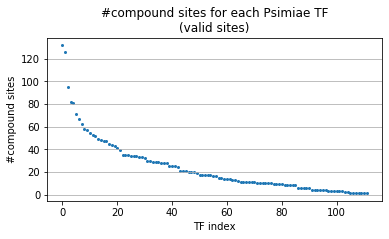

In [9]:
fig, ax = plt.subplots(figsize=(6,3))
counts = df_merged_valid['tf_id'].value_counts().sort_values()
tf_ids = df_merged_valid['tf_id'].unique()

y = sorted(counts.values, reverse=True)
x = range(len(y))
plt.scatter(x, y, s=4)
plt.grid(True, axis='y')
plt.xlabel('TF index')
plt.ylabel('#compound sites')
plt.title(f'#compound sites for each Psimiae TF\n(valid sites)')
plt.show()

In [10]:
fig, ax = plt.subplots(figsize=(22,3))
counts = df_merged_valid['tf_id'].value_counts()

y = counts.values
x = range(len(y))
ticks = counts.index.values

plt.scatter(x, y, s=4)
plt.grid(True, axis='y')
plt.xticks(x, ticks, rotation=90)
plt.xlabel('TF no')
plt.ylabel('#compound sites')
plt.title(f'#compound sites for each Psimiae TF\n(valid sites)')
plt.show()

## TFs per promoter

In [11]:
fig, ax = plt.subplots(figsize=(4,3))
y = sorted(counts.values, reverse=True)
x = range(len(y))
df_merged_valid['intergenic_label'].value_counts().hist(bins=[1,2,3,4,5,6,7,])
plt.grid(True, axis='y')
plt.ylabel('Count')
plt.xlabel('#Distinct TFs')
plt.yscale('log')
plt.xticks([1,2,3,4,5,6,])
plt.title(f'#distinct TFs binding to each intergenic region\n(valid sites)')
plt.show()

## Promoters per TF

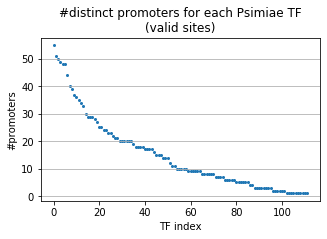

In [12]:
fig, ax = plt.subplots(figsize=(5,3))
counts = df_merged_valid.groupby('tf_id')['intergenic_label'].nunique()
y = sorted(counts.values, reverse=True)
x = range(len(y))
plt.scatter(x, y, s=4)
plt.grid(True, axis='y')
plt.xlabel('TF index')
plt.ylabel('#promoters')
plt.title(f'#distinct promoters for each Psimiae TF\n(valid sites)')
plt.show()

## Number of compound sites per TF per promoter

In [13]:
df_groups = df_merged_valid.groupby(['tf_id'])
count_list = []
num_min_sites = 2
for group_name, df_group in df_groups:
    #Count number of promoters with at least two compound site for this tf
    count = np.sum(df_group['intergenic_label'].value_counts()>=num_min_sites)
    count_list += [(group_name, count)]
    
names = ['TF', 'num_promoters_w_2_or_more_compound_sites']
df_site_counts = pd.DataFrame(count_list, columns=names)

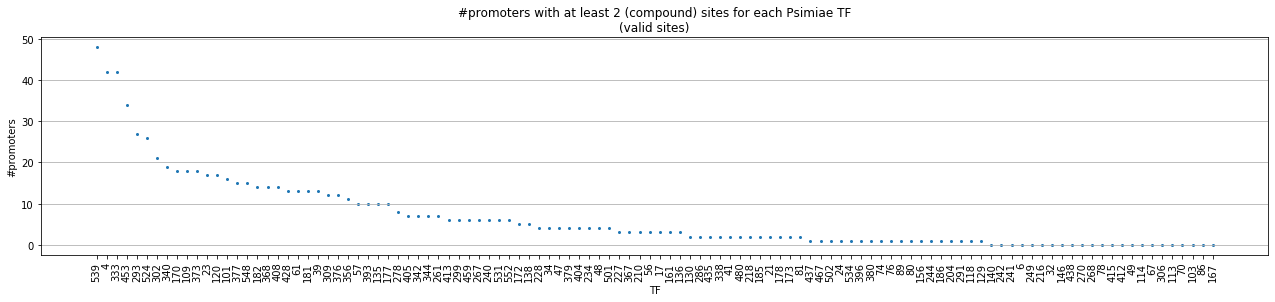

In [14]:
df_site_counts = df_site_counts.sort_values(by='num_promoters_w_2_or_more_compound_sites', ascending=False)

fig, ax = plt.subplots(figsize=(22,4))
y = df_site_counts['num_promoters_w_2_or_more_compound_sites']
x = range(len(df_site_counts))
ticks = df_site_counts['TF']
plt.scatter(x, y, s=4)
plt.xticks(x, ticks, rotation=90)
plt.grid(True, axis='y')
plt.xlabel('TF')
plt.ylabel('#promoters')
plt.title(f'#promoters with at least {num_min_sites} (compound) sites for each Psimiae TF\n(valid sites)')
plt.show()

In [15]:
np.sum(df_site_counts >= 1)

TF                                          112
num_promoters_w_2_or_more_compound_sites     89
dtype: int64

## Plot distances between compound sites

In [16]:
df_colors = pd.read_pickle('tf_class_colors.pkl.gz')

In [17]:
tf_ids = df_merged_valid.tf_id.unique()
num_min_sites = 2
tf_distances = []
for tf_id in tf_ids:
    # Select records for this tf 
    tf_filter = (df_merged_valid.tf_id == tf_id)
    df_tf = df_merged_valid[tf_filter].sort_values(by='start')

    dummy_distances = []
    # Group by integenic region
    df_groups = df_tf.groupby(['intergenic_label'])
    for group_name, df_group in df_groups:
        # Select regions with at least 2 compound sites for this tf 
        if len(df_group) == 2:
            index_1, index_2 = df_group.index.values
            # Check if entries are sorted by the start coord
            start_1 = df_group.loc[index_1].start
            start_2 = df_group.loc[index_2].start
            end_1 = df_group.loc[index_1].end
            end_2 = df_group.loc[index_2].end

            if  start_1 > start_2:
                print(f"{group_name} sites are not ordered.")
                break
    
            # Calculate Outer distance
            end_to_end_dist = end_2 - start_1        
            in_between_dist = start_2 - end_1
            if tf_id == 340:
                print(tf_id, group_name, end_to_end_dist, in_between_dist)
                
            tf_distances += [[tf_id, end_to_end_dist, in_between_dist]]      
            
            
df_tf_distances = pd.DataFrame(tf_distances, columns=["tf_id", "outer_distance", "inner_distance"])

340 CP007637.1:01011 13 -5
340 NC_000964.3:00364 13 -5
340 NC_002516.2:00921 13 -5
340 NC_002516.2:02465 40 22
340 NC_002947.4:00960 13 -5
340 NC_014323.1:01584 20 2
340 NC_014323.1:04023 31 13
340 NC_019936.1:01071 13 -5
340 NZ_CP012830.1:01912 40 22
340 NZ_CP012830.1:01913 33 15
340 NZ_CP012830.1:02908 13 -5
340 NZ_CP012831.1:00921 13 -5
340 NZ_CP015225.1:02527 13 -5
340 NZ_CP015225.1:03460 33 15
340 NZ_JIBE01000003.1:00681 40 22
340 NZ_KK211142.1:03118 40 22
340 NZ_LKBJ01000002.1:04014 13 -5
340 NZ_LUKJ01000003.1:03561 13 -5
340 NZ_LUKZ01000014.1:02716 40 22


In [18]:
df_tf_dist_crosstab = pd.crosstab(df_tf_distances.tf_id, df_tf_distances.outer_distance)

# Define a sort order for TFs.
# Sort by minimum distance
df_tf_min_dist = df_tf_distances.groupby('tf_id')['outer_distance'].min()
tfs_sorted_by_min_dist = df_tf_min_dist.sort_values().index

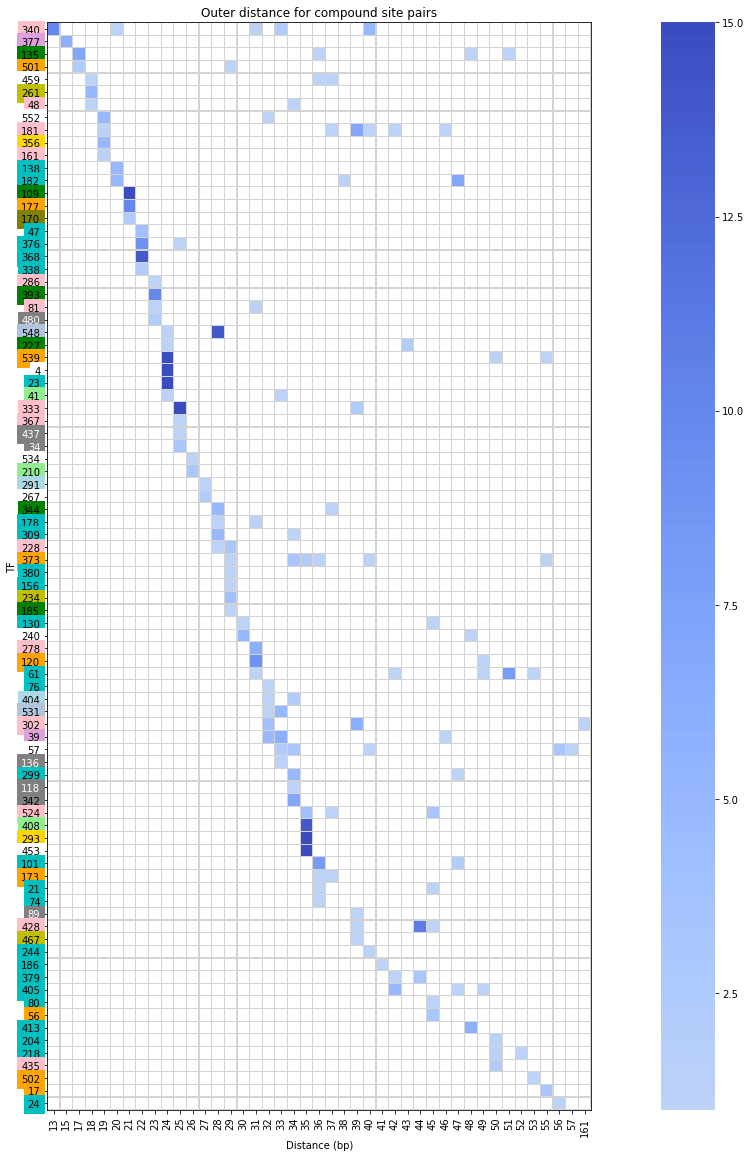

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
df_heatmap = df_tf_dist_crosstab.loc[tfs_sorted_by_min_dist]
vmax = df_heatmap.describe().loc['max'].max()
mask = df_heatmap.values == 0
fig, ax = plt.subplots(figsize=(25,20))   
fig.patch.set_facecolor("white")
sns.heatmap(df_tf_dist_crosstab.loc[tfs_sorted_by_min_dist],
            ax=ax, cmap='coolwarm_r',center=-3, vmin=1, vmax=15,
            linewidths=0.1, linecolor='lightgrey', square=True, mask=mask)

for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.title('Outer distance for compound site pairs')
plt.xlabel('Distance (bp)')
plt.ylabel('TF')
tf_nos_list = df_colors.index.values

for tick_obj in ax.yaxis.get_ticklabels():
    tf_no = int(tick_obj.get_text())
    if tf_no in tf_nos_list:
        color = df_colors.loc[tf_no]['class']
        tick_obj.set_backgroundcolor(color)
    else:
        tick_obj.set_backgroundcolor("gray")
        tick_obj.set_color("w")

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [20]:
#tf_no
df_colors.index.values

array([  4,   6,  17,  20,  21,  23,  24,  30,  32,  39,  41,  47,  48,
        49,  56,  57,  59,  61,  67,  70,  74,  76,  78,  80,  81,  86,
       101, 103, 109, 113, 114, 116, 120, 130, 135, 138, 146, 156, 161,
       167, 170, 172, 173, 177, 178, 181, 182, 185, 186, 204, 210, 218,
       221, 227, 228, 234, 240, 241, 244, 249, 261, 267, 268, 270, 278,
       286, 291, 293, 299, 302, 306, 309, 329, 333, 335, 338, 340, 342,
       344, 356, 358, 367, 368, 373, 376, 377, 379, 380, 393, 404, 405,
       408, 412, 413, 415, 428, 435, 438, 453, 459, 467, 501, 502, 524,
       531, 534, 539, 548, 552])

### Binned heatmap for Outer distance

The plot above shows all distances that appear. I bin them to reduce the noise a bit. ( Distances may fluctuate a bit for biological reasons, also motif caller could make small errors in locating the binding site.)

In [21]:
binsize = 5
bins = range(0, 280, binsize)

tf_ids = []
binned_distances_list = []
df_groups = df_tf_distances.groupby(['tf_id'])

for tf, df_group in df_groups:        
    tf_ids += [tf]
    distances = df_group.outer_distance.values
    binned_distances, dummy_bins = np.histogram(distances, bins)
    binned_distances_list += [list(binned_distances)]
    
df_binned_distances = pd.DataFrame(binned_distances_list, columns=bins[:-1])
df_binned_distances['tf_id'] = tf_ids
df_binned_distances = df_binned_distances.set_index('tf_id')

(86.0, 0.0)

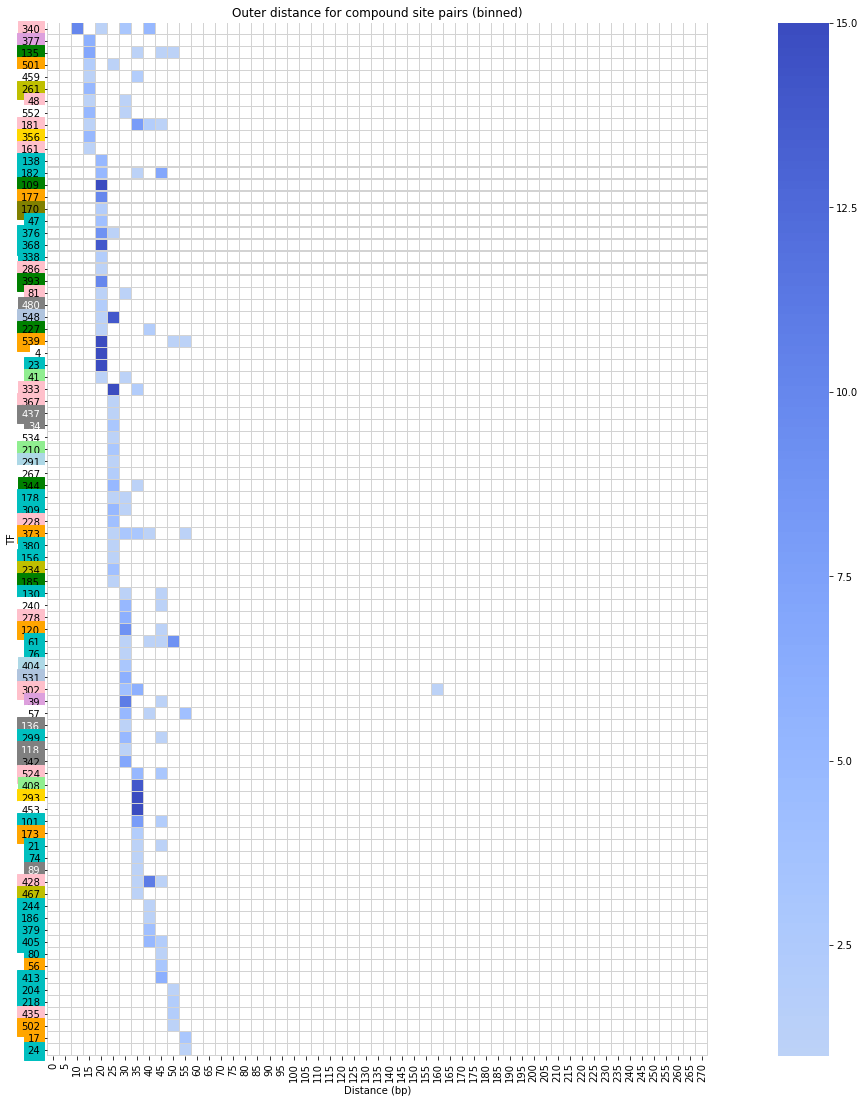

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
df_heatmap = df_binned_distances.loc[tfs_sorted_by_min_dist]

vmax = df_heatmap.describe().loc['max'].max()
mask = df_heatmap.values == 0
fig, ax = plt.subplots(figsize=(25,19))   
fig.patch.set_facecolor("white")
sns.heatmap(df_binned_distances.loc[tfs_sorted_by_min_dist],
            ax=ax, cmap='coolwarm_r',center=-3, vmin=1, vmax=15,
            linewidths=0.1, linecolor='lightgrey', square=True, mask=mask)

tf_nos_list = df_colors.index.values

for tick_obj in ax.yaxis.get_ticklabels():
    tf_no = int(tick_obj.get_text())
    if tf_no in tf_nos_list:
        color = df_colors.loc[tf_no]['class']
        tick_obj.set_backgroundcolor(color)
    else:
        tick_obj.set_backgroundcolor("gray")
        tick_obj.set_color("w")

plt.title('Outer distance for compound site pairs (binned)')
plt.xlabel('Distance (bp)')
plt.ylabel('TF')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update

## Inner distance

In [23]:
df_tf_dist_crosstab = pd.crosstab(df_tf_distances.tf_id, df_tf_distances.inner_distance)

# Define a sort order for TFs.
# Sort by minimum distance
df_tf_min_dist = df_tf_distances.groupby('tf_id')['inner_distance'].min()
tfs_sorted_by_min_dist = df_tf_min_dist.sort_values().index

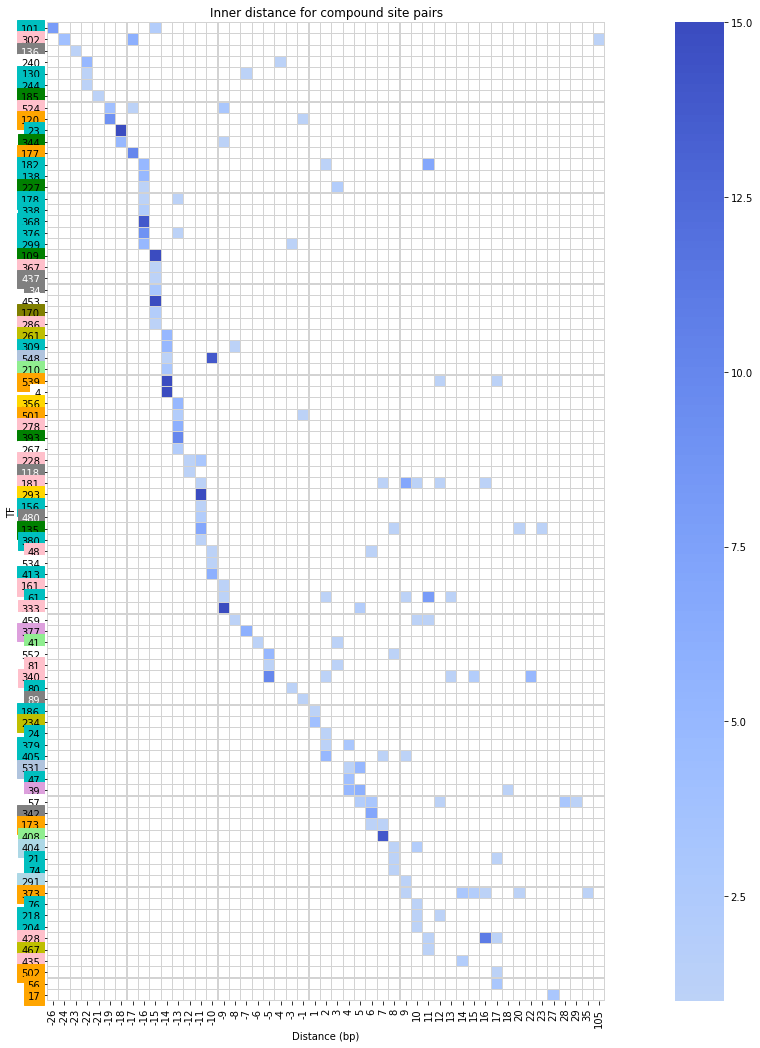

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
df_heatmap = df_tf_dist_crosstab.loc[tfs_sorted_by_min_dist]
vmax = df_heatmap.describe().loc['max'].max()
mask = df_heatmap.values == 0
fig, ax = plt.subplots(figsize=(25,18))   
fig.patch.set_facecolor("white")
sns.heatmap(df_tf_dist_crosstab.loc[tfs_sorted_by_min_dist],
            ax=ax, cmap='coolwarm_r',center=-3, vmin=1, vmax=15,
            linewidths=0.1, linecolor='lightgrey', square=True, mask=mask)
plt.title('Inner distance for compound site pairs')
plt.xlabel('Distance (bp)')
plt.ylabel('TF')
tf_nos_list = df_colors.index.values

for tick_obj in ax.yaxis.get_ticklabels():
    tf_no = int(tick_obj.get_text())
    if tf_no in tf_nos_list:
        color = df_colors.loc[tf_no]['class']
        tick_obj.set_backgroundcolor(color)
    else:
        tick_obj.set_backgroundcolor("gray")
        tick_obj.set_color("w")
  
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

### Binned heatmap for Inner distance

The plot above shows all distances that appear. I bin them to reduce the noise a bit. ( Distances may fluctuate a bit for biological reasons, also motif caller could make small errors in locating the binding site.)

In [25]:
binsize = 5
bins = range(0, 200, binsize)

tf_ids = []
binned_distances_list = []
df_groups = df_tf_distances.groupby(['tf_id'])

for tf, df_group in df_groups:        
    tf_ids += [tf]
    distances = df_group.inner_distance.values
    binned_distances, dummy_bins = np.histogram(distances, bins)
    binned_distances_list += [list(binned_distances)]
    
df_binned_distances = pd.DataFrame(binned_distances_list, columns=bins[:-1])
df_binned_distances['tf_id'] = tf_ids
df_binned_distances = df_binned_distances.set_index('tf_id')

(86.0, 0.0)

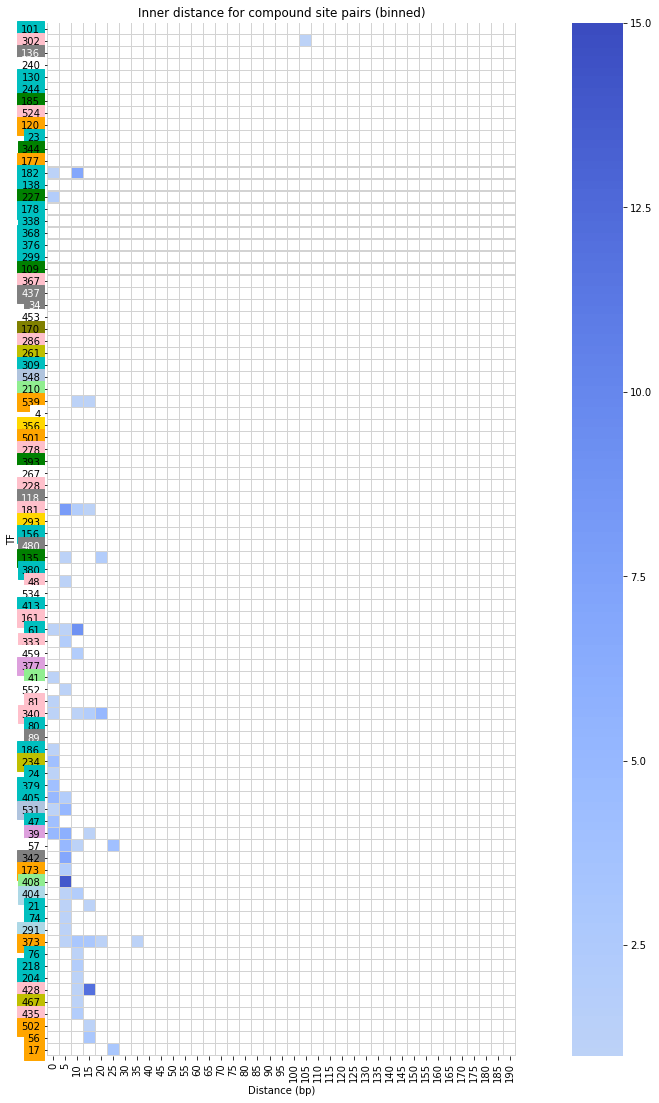

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
df_heatmap = df_binned_distances.loc[tfs_sorted_by_min_dist]

vmax = df_heatmap.describe().loc['max'].max()
mask = df_heatmap.values == 0
fig, ax = plt.subplots(figsize=(20,19))   
fig.patch.set_facecolor("white")
sns.heatmap(df_binned_distances.loc[tfs_sorted_by_min_dist],
            ax=ax, cmap='coolwarm_r',center=-3, vmin=1, vmax=15,
            linewidths=0.1, linecolor='lightgrey', square=True, mask=mask)

plt.title('Inner distance for compound site pairs (binned)')
plt.xlabel('Distance (bp)')
plt.ylabel('TF')
tf_nos_list = df_colors.index.values

for tick_obj in ax.yaxis.get_ticklabels():
    tf_no = int(tick_obj.get_text())
    if tf_no in tf_nos_list:
        color = df_colors.loc[tf_no]['class']
        tick_obj.set_backgroundcolor(color)
    else:
        tick_obj.set_backgroundcolor("gray")
        tick_obj.set_color("w")

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update

## How many TFs with irregular spacing between sites?

In [27]:
irregulars = 0
regulars = 0
for index, item in df_tf_dist_crosstab.iterrows():
    spacings = np.sum(item > 0)
    
    # Count irregulars
    if spacings > 1:
        irregulars += 1
    else:
        regulars += 1

print(regulars, irregulars)

48 38


# Orientations

In [28]:
df = df_merged_valid[['tf_id', 'orientation']].copy()
ori_values = []
for index, row in df.iterrows():
    ori = row.orientation 
    if ori == "both":
        val = 0
    elif ori == '+' or ori == "-":
        val = 1
    else:
        print("Something wrong with orientation:", ori)
    
    ori_values += [val]

df['directionality'] = ori_values

In [29]:
counts = df.groupby('tf_id')['directionality'].mean()
counts.sort_values(inplace=True)

In [30]:
df[df.tf_id==146]

tf_id orientation  directionality
4778    146           +               1
4780    146           +               1
4781    146           +               1

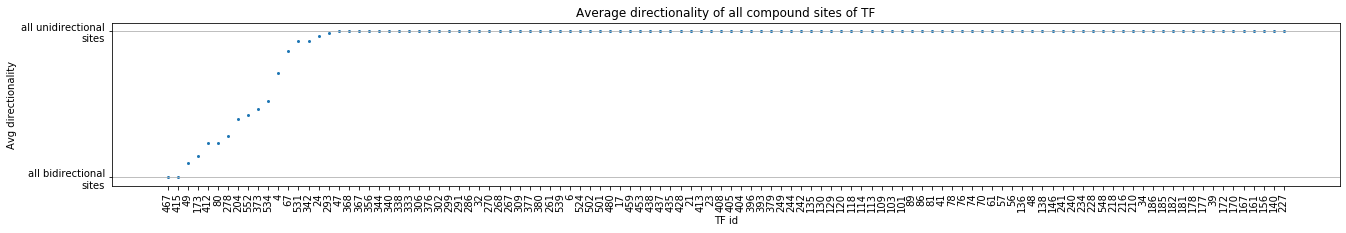

In [31]:
fig, ax = plt.subplots(figsize=(22,3))
y = counts.values
x = range(len(y))
ticks = counts.index.values
plt.scatter(x, y, s=4)
plt.grid(True, axis='y')
plt.xlabel('TF id')
plt.ylabel('Avg directionality')
plt.yticks([0,1],['all bidirectional\nsites', 'all unidirectional\nsites'])
plt.xticks(x, ticks, rotation=90)
plt.title(f'Average directionality of all compound sites of TF')
plt.show()

# Distribution of midpoint to start codon for all ortho sites

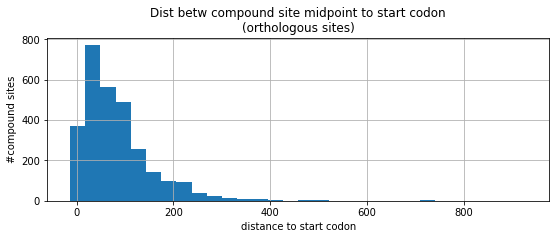

In [32]:
select_ortho = df_all_occurrences_merged.target_is_ortho  
df_merged_ortho = df_all_occurrences_merged[select_ortho] 

fig, ax = plt.subplots(figsize=(9,3))
counts = df_merged_ortho['tf_id'].value_counts()
y = counts.values
x = counts.index.values
df_merged_ortho.dist_to_pref_tgt.hist(bins=30)
plt.grid(True, axis='y')
plt.xlabel('distance to start codon')
plt.ylabel('#compound sites')
plt.title(f'Dist betw compound site midpoint to start codon\n(orthologous sites)')
plt.show()

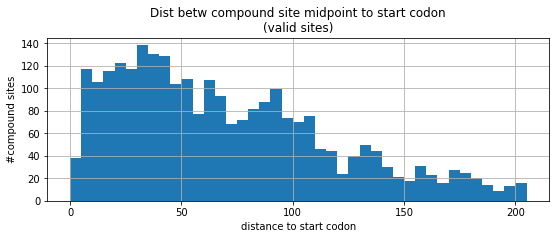

In [33]:
fig, ax = plt.subplots(figsize=(9,3))
# counts = df_merged_ortho['tf_id'].value_counts()
# y = counts.values
# x = counts.index.values
bins = range(0,max_dist+1,5)
df_merged_valid.dist_to_pref_tgt.hist(bins=bins)
plt.grid(True, axis='y')
plt.xlabel('distance to start codon')
plt.ylabel('#compound sites')
plt.title(f'Dist betw compound site midpoint to start codon\n(valid sites)')
plt.show()

In [34]:
def plot_tf_sites(df, tf_id, only_psimiae=False):
    bins = range(0,max_dist+1,5)
    select = (df.tf_id == tf_id) 
    if only_psimiae:
        select = select & (df.species == "Pseudomonas_simiae_WCS417")

    df_this_tf = df[select]
    print(len(df_this_tf))
    fig, ax = plt.subplots(figsize=(9,3))
    df_this_tf.dist_to_pref_tgt.hist(bins=bins)
    plt.grid(True, axis='y')
    plt.xlabel('distance')
    plt.ylabel('#count')
    #plt.yticks([0,1,2])
    title = f'TF={tf_id}, Dist betw compound site midpoint to start codon\n(valid sites)'
    if only_psimiae:
        title += " only P.simiae targets"
    plt.title(title)
    plt.show()

In [35]:
tf_ids = df_merged_valid['tf_id'].unique()

In [36]:
tf_ids[-10:]

array([467, 480, 501, 502, 524, 531, 534, 539, 548, 552])

2


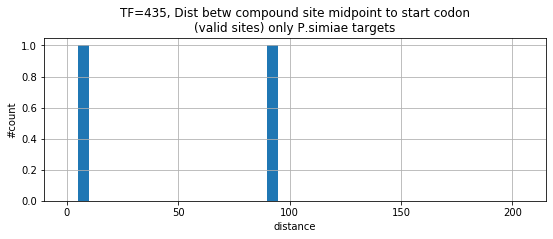

24


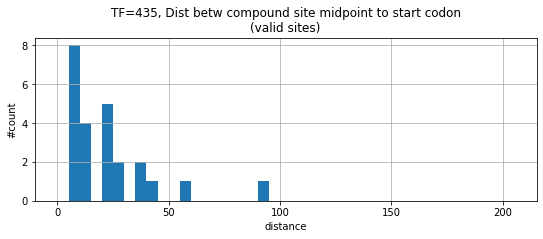





2


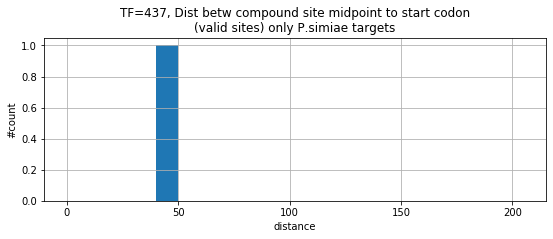

2


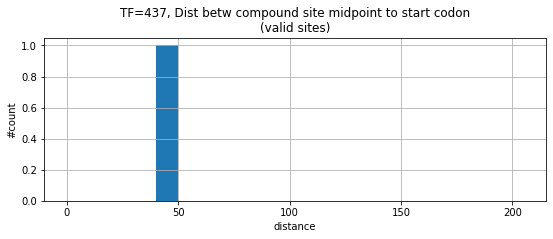





3


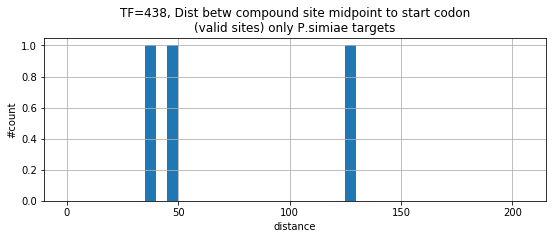

11


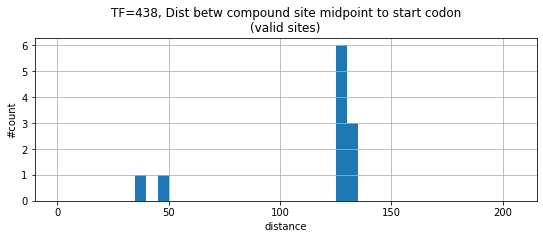





2


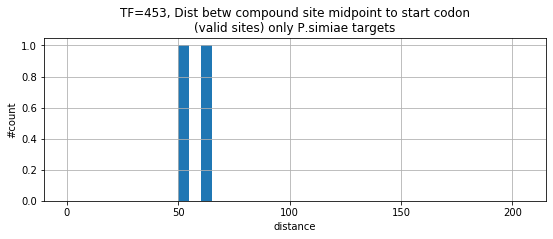

82


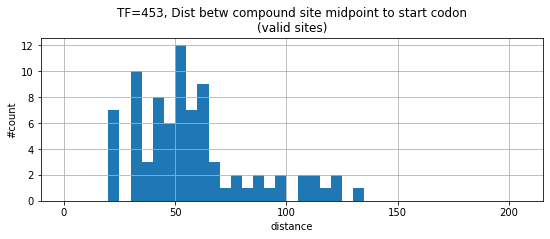





2


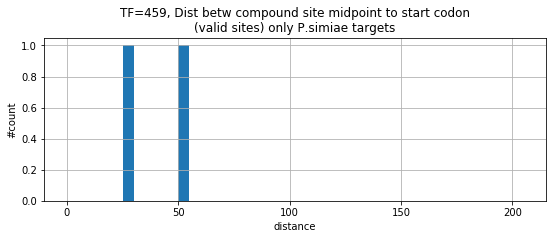

15


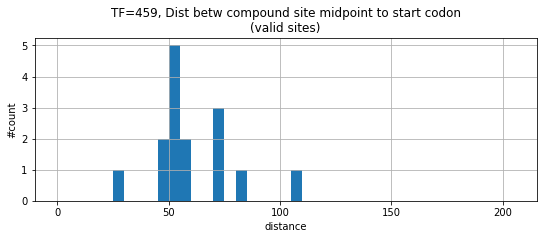

In [37]:
for tf in tf_ids[-15:-10]:
    plot_tf_sites(df_merged_valid, tf, only_psimiae=True)
    plot_tf_sites(df_merged_valid, tf, only_psimiae=False)
    print("\n\n\n")
    #if tf > 150:
    #    break

# Mean site length

## All valid

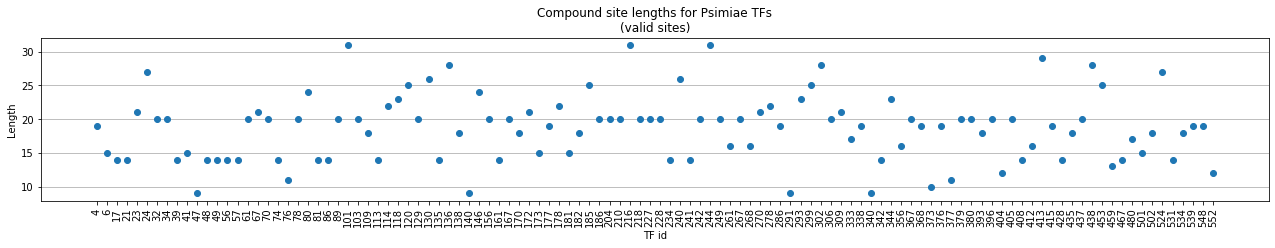

In [38]:
fig, ax = plt.subplots(figsize=(22,3))
lengths = df_merged_valid.groupby('tf_id')['length'].mean()
stdevs = df_merged_valid.groupby('tf_id')['length'].std()

#y = sorted(lengths.values, reverse=True)
y = lengths.values
x = range(len(y))
ticks = lengths.index.values
plt.errorbar(x, y, stdevs, fmt='o')
plt.grid(True, axis='y')
plt.xlabel('TF id')
plt.ylabel('Length')
plt.xticks(x, ticks, rotation=90)
plt.title(f'Compound site lengths for Psimiae TFs\n(valid sites)')
plt.show()

## Only abundant TFs

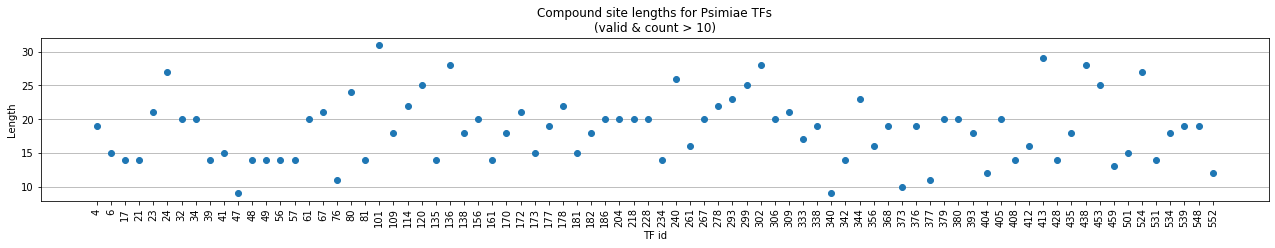

In [39]:
abundant_tf_ids = counts[counts >= 10].index.values
select_abundant = df_merged_valid['tf_id'].isin(abundant_tf_ids)
df_abundant = df_merged_valid[select_abundant]

fig, ax = plt.subplots(figsize=(22,3))
lengths = df_abundant.groupby('tf_id')['length'].mean()
stdevs = df_abundant.groupby('tf_id')['length'].std()

#y = sorted(lengths.values, reverse=True)
y = lengths.values
x = range(len(y))
ticks = lengths.index.values
plt.errorbar(x, y, stdevs, fmt='o')
plt.grid(True, axis='y')
plt.xlabel('TF id')
plt.ylabel('Length')
plt.xticks(x, ticks, rotation=90)
plt.title(f'Compound site lengths for Psimiae TFs\n(valid & count > 10)')
plt.show()

# Do TFs prefer to be at a certain distance for regulation?

## Target species: all

In [40]:
abundant_tf_ids = counts[counts >= 10].index.values

In [41]:
len(abundant_tf_ids)

81

In [42]:
bins = range(0,max_dist+1,5)
all_tfs_hist = []

for tf in abundant_tf_ids:
    #fig, ax = plt.subplots(figsize=(9,3))

    counts = df_merged_valid['tf_id'].value_counts()
    select_tf = df_merged_valid.tf_id == tf
    df_select_tf = df_merged_valid[select_tf]
    distances = df_select_tf.dist_to_pref_tgt.values
    hist = np.histogram(distances, bins, density=False) 
    all_tfs_hist += [list(hist[0])]
    
# Create a df from histograms
num_bins = len(bins) - 1
column_names = bins[:num_bins]
df_heatmap = pd.DataFrame(all_tfs_hist, columns=column_names)
df_heatmap = df_heatmap.set_index(abundant_tf_ids)

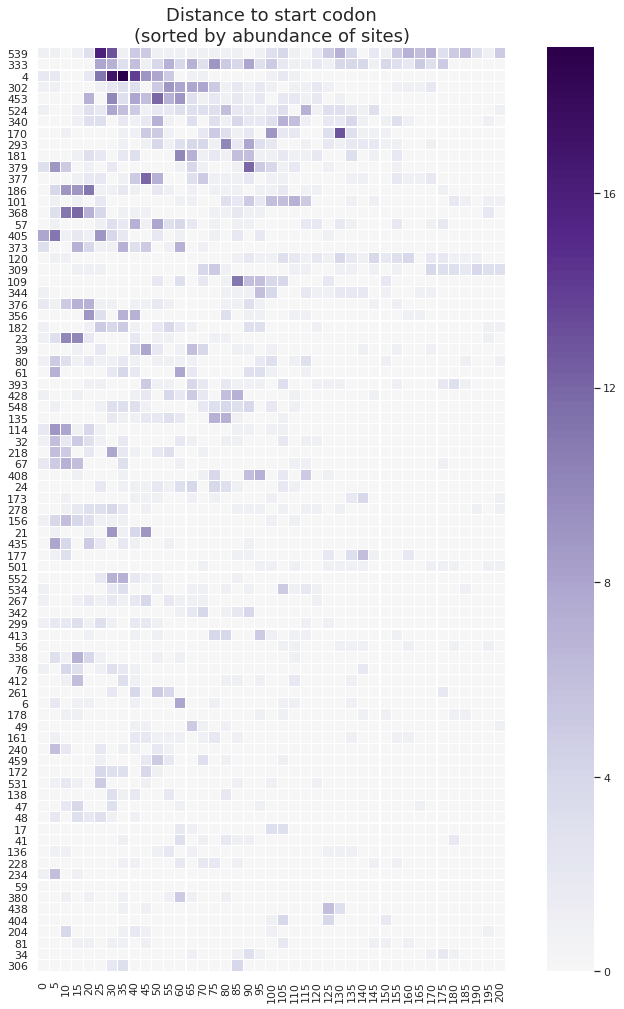

In [43]:
import seaborn as sns
vmax = df_heatmap.describe().loc['max'].max()
sns.set(font_scale=1)
figsize = (15,17)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title("Distance to start codon\n(sorted by abundance of sites)", fontsize=18)

ax = sns.heatmap(df_heatmap,
     center=0, vmin=0, vmax=vmax,
     cmap='PuOr', ax=ax,
     linewidths=0.1, square=True)

    
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

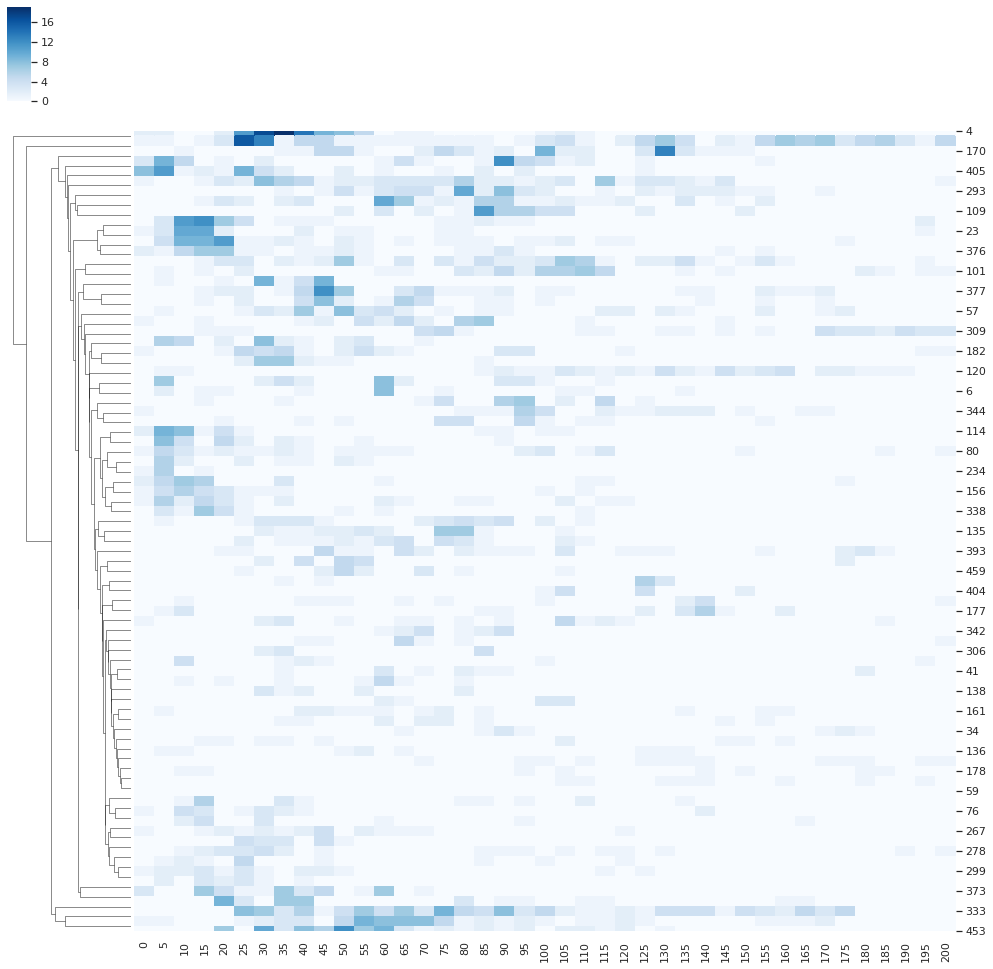

In [44]:
figsize=(17,17)
sns.set(font_scale=1)
sns.clustermap(df_heatmap, figsize=figsize, col_cluster=False, cmap='Blues')

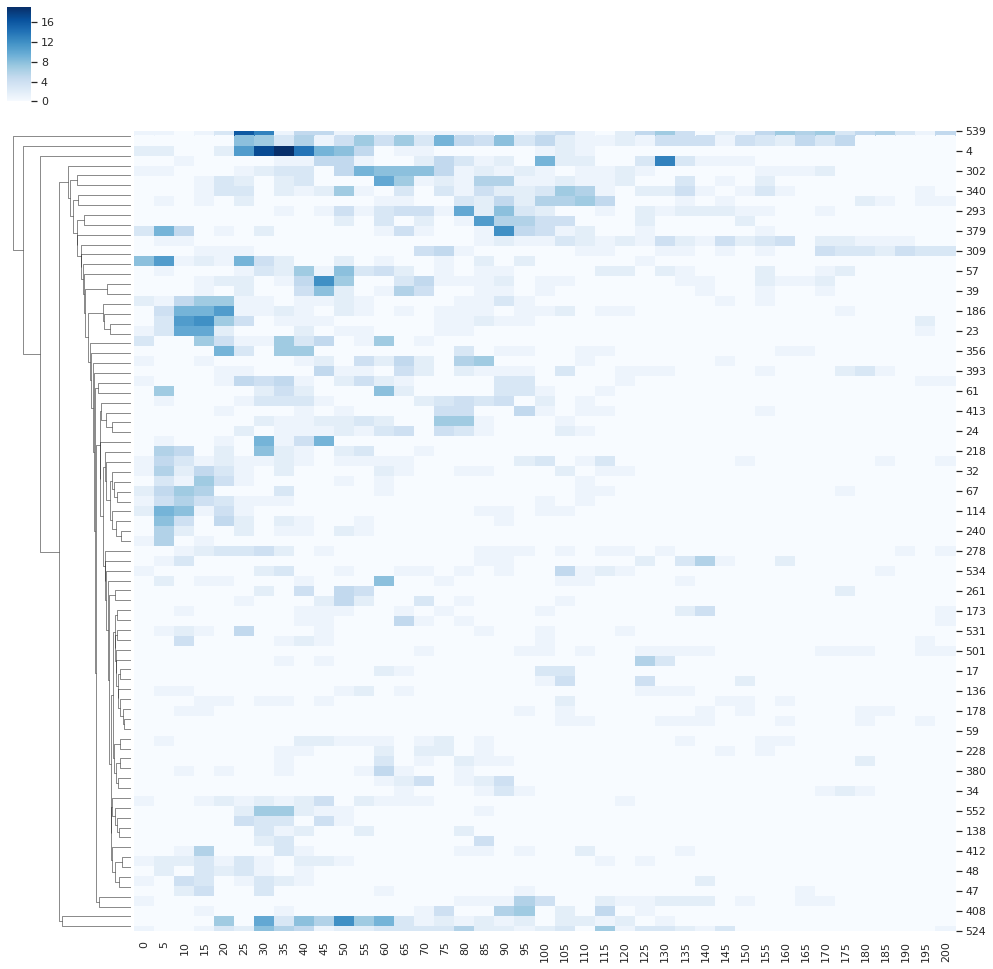

In [45]:
figsize=(17,17)
sns.clustermap(df_heatmap, figsize=figsize, col_cluster=False, metric='cityblock', cmap='Blues')

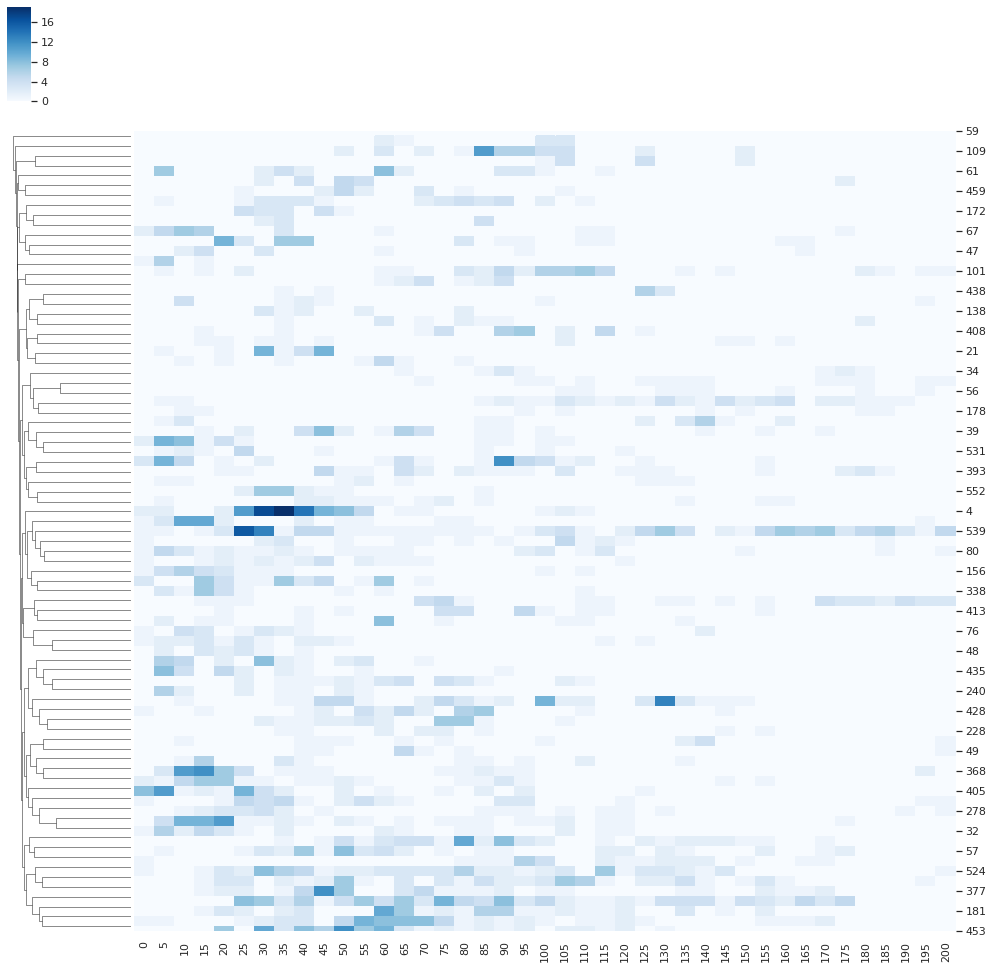

In [46]:
sns.clustermap(df_heatmap, figsize=figsize, col_cluster=False, metric='jaccard', cmap='Blues')